In [22]:

#Drive connection
!sudo echo -ne '\n' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing
!sudo apt update >/dev/null 2>&1
!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1
!google-drive-ocamlfuse
!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser
!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser
%cd /content
!mkdir gdrive
%cd gdrive
!mkdir "My Drive"
!google-drive-ocamlfuse "/content/gdrive/My Drive"

/content
mkdir: cannot create directory ‘gdrive’: File exists
/content/gdrive
mkdir: cannot create directory ‘My Drive’: File exists
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [23]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from warnings import filterwarnings
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.io as pio

filterwarnings('ignore')


In [24]:
#Main directory
DIR = "/content/gdrive/My Drive/Meta_Asr/Data_Annotation/Audios_Clusturing/"
# define the Raw and Pre_Processed MetaFeatures Data
PATH_RAW_DATA = '/content/gdrive/My Drive/Meta_Asr/Data_Annotation/Meta_Features_Data/Raw_MetaFeatures_Data.csv'
PATH_PREPROCESSED_DATA = "/content/gdrive/My Drive/Meta_Asr/Data_Annotation/Meta_Features_Data/PreProcessed_MetaFeatures_Data.csv"

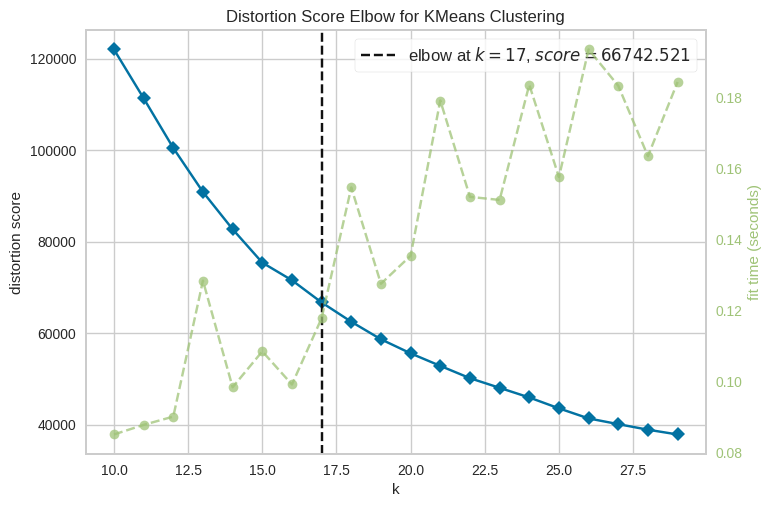

Data path: /content/gdrive/My Drive/Meta_Asr/Data_Annotation/Meta_Features_Data/Raw_MetaFeatures_Data.csv
Number of clusters: 17
The average Silhouette Score is: 0.39313886
WCSS: 66438.43953479826


/content/gdrive/My Drive/Meta_Asr/Data_Annotation/Audios_Clusturing/RawData_MetaFeatureClustered.csv


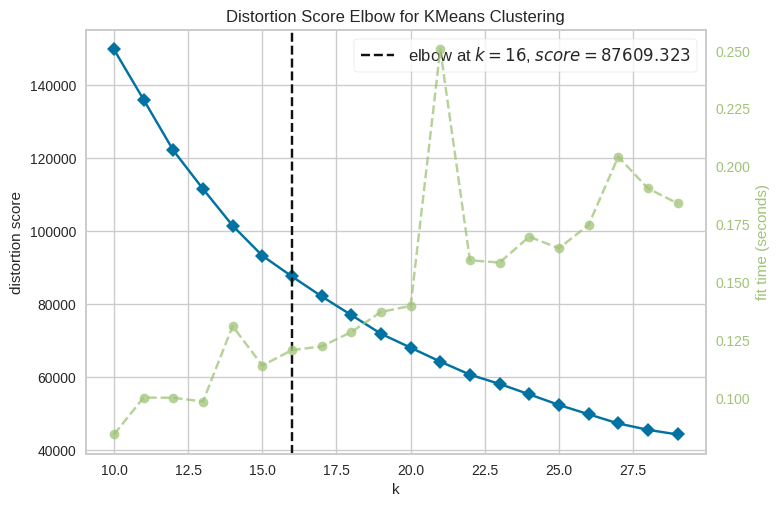

Data path: /content/gdrive/My Drive/Meta_Asr/Data_Annotation/Meta_Features_Data/PreProcessed_MetaFeatures_Data.csv
Number of clusters: 16
The average Silhouette Score is: 0.3804074
WCSS: 89301.5257262718


/content/gdrive/My Drive/Meta_Asr/Data_Annotation/Audios_Clusturing/PreProcessed_MetaFeatureClustered.csv


In [25]:
#configuration setup
def setup(filename):
  try:
    os.mkdir(filename)
  except OSError:
    pass


#load data
def load_data(path):
   df = pd.read_csv(path,index_col=0)
   return df

def optimal_number_of_clusters(data):
  # Preprocess the Data
  data = data.dropna() # Remove null values
  data = data.select_dtypes(include=[np.number]) # Keep only numerical data
  # Apply t-SNE
  tsne = TSNE(n_components=2, perplexity=30, learning_rate=200,random_state=42)
  tsne_data = tsne.fit_transform(data)
  #define Kmeans model
  model = KMeans()
  visualizer = KElbowVisualizer(model, k=(10,30))
  visualizer.fit(tsne_data)
  # Get the optimal value of k
  k = visualizer.elbow_value_
  visualizer.show()
  return k


def cluster_data(path,k,data_name):
  df = pd.read_csv(path)
  df1= df.dropna() # Remove null values
  df1 = df1.select_dtypes(include=[np.number]) # Keep only numerical data

  # Apply t-SNE
  tsne = TSNE(n_components=2, perplexity=30, learning_rate=200,random_state=42)
  tsne_data = tsne.fit_transform(df1)
  # Apply K-Means
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(tsne_data)
  labels_tsne= kmeans.labels_
  #add the cluster columents to data
  df['cluster']=labels_tsne
  # Calculate Silhouette Score
  silhouette_avg = silhouette_score(tsne_data, labels_tsne)
  print("The average Silhouette Score is:", silhouette_avg)
  # Calculate WCSS
  wcss = sum(np.min(kmeans.transform(tsne_data), axis=1)**2)
  print("WCSS:", wcss)
  # Visualize the Clusters
  fig = px.scatter(x=tsne_data[:,0], y=tsne_data[:,1], color=labels_tsne, data_frame=df, color_continuous_scale='rainbow')
  fig.update_layout(width=500, height=600, title='Clusters')
  # Save the plot as a figure
  fig.show()
  return df

#save the cluster dataset

def save_data(data,data_name):
  path_clusterData= DIR+data_name+'.csv'
  df=data.sort_values('cluster')
  df.to_csv(path_clusterData,index=0)
  print(path_clusterData)
  return path_clusterData



def create_ClusterData(cluster_DataPath,data_name,groundTruthDataname='ClusterData_'):
  previous_cluster = None
  groundTruth = list()
  #load data
  data = pd.read_csv(cluster_DataPath)
  for cluster, audio in zip(data["cluster"],data["Audio"]):
    if previous_cluster is None or cluster != previous_cluster:
        groundTruth.append([cluster,audio])
        previous_cluster = cluster
  df = pd.DataFrame(groundTruth,columns =['cluster','Reference_Audios'])
  df.to_csv(DIR+groundTruthDataname+data_name+'.csv',index=0)




def cluster_audio_data(data_path):
  setup(DIR)
  if data_path == PATH_RAW_DATA:
    data_name='RawData_MetaFeatureClustered'
    # Charger les données à partir du fichier CSV
    df1 = load_data(data_path)
    # Obtenir le nombre optimal de clusters
    k = optimal_number_of_clusters(df1)
    # Afficher les résultats
    print(f"Data path: {data_path}\nNumber of clusters: {k}")
    # Effectuer le clustering avec le nombre optimal de clusters
    df=cluster_data(data_path,k,data_name)
    #save the data
    path_clusterData=save_data(df,data_name)
    #create the groundTruth
    create_ClusterData(path_clusterData,data_name)
  else:
    data_name='PreProcessed_MetaFeatureClustered'
    # Charger les données à partir du fichier CSV
    df2 = load_data(data_path)
    # Obtenir le nombre optimal de clusters
    k = optimal_number_of_clusters(df2)
    # Afficher les résultats
    print(f"Data path: {data_path}\nNumber of clusters: {k}")
    # Effectuer le clustering avec le nombre optimal de clusters
    df=cluster_data(data_path,k,data_name)
    #save the data
    path_clusterData=save_data(df,data_name)
    #create the groundTruth
    create_ClusterData(path_clusterData,data_name)


if __name__ == '__main__':
  # Cluster les données brutes
  cluster_audio_data(PATH_RAW_DATA)
  # Cluster les données prétraitées
  cluster_audio_data(PATH_PREPROCESSED_DATA)




